In [51]:
# Cell 1: Import libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import welch
import matplotlib.pyplot as plt

print("Libraries imported successfully!")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Libraries imported successfully!
Using device: cuda


In [50]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

print("EarlyStopping class defined!")

EarlyStopping class defined!


In [52]:
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]
clean_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean"
contaminated_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated"

# Check if paths exist
print(f"Clean directory exists: {os.path.exists(clean_dir)}")
print(f"Contaminated directory exists: {os.path.exists(contaminated_dir)}")
print(f"Working with {len(bands)} frequency bands: {bands}")

Clean directory exists: True
Contaminated directory exists: True
Working with 6 frequency bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [54]:
class AdvancedLSTM(nn.Module):
    def __init__(self, input_length):
        super(AdvancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=3, batch_first=True, dropout=0.3)
        self.layer_norm = nn.LayerNorm(512)
        self.fc = nn.Linear(512, input_length)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, seq_length, channels)
        x, _ = self.lstm(x)  # LSTM output
        x = self.layer_norm(x[:, -1, :])  # Apply layer normalization on the last hidden state
        x = self.fc(x)
        return x
    print("AdvancedLSTM model defined!")

AdvancedLSTM model defined!


In [47]:
"""
Step 6: Define Helper Functions
"""

# Normalize signals
def normalize_signals(data):
    """Normalize the signals to zero mean and unit variance per sample."""
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

# Plot Signals
def plot_signals(contaminated, denoised, ground_truth, sample_indices, title):
    num_samples = len(sample_indices)
    plt.figure(figsize=(12, 4 * num_samples))
    for i, idx in enumerate(sample_indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(contaminated[idx], label="Contaminated Signal", alpha=0.6)
        plt.plot(denoised[idx], label="Denoised Signal", alpha=0.8)
        plt.plot(ground_truth[idx], label="Ground Truth Signal", alpha=0.8)
        plt.title(f"{title} - Sample {idx}")
        plt.xlabel("Time Points")
        plt.ylabel("Amplitude")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Print confirmation
print("Helper functions defined successfully.")


Helper functions defined successfully.


In [55]:
def compute_rrmse_t(clean, denoised):
    per_sample_rrmse = np.sqrt(np.sum((clean - denoised) ** 2, axis=1) / np.sum(clean ** 2, axis=1))
    return np.mean(per_sample_rrmse)

def compute_rrmse_s(clean, denoised, fs):
    f_clean, psd_clean = welch(clean.flatten(), fs=fs, nperseg=512)
    f_denoised, psd_denoised = welch(denoised.flatten(), fs=fs, nperseg=512)
    return np.sqrt(np.sum((psd_clean - psd_denoised) ** 2) / np.sum(psd_clean ** 2))

def compute_cc(clean, denoised):
    return np.corrcoef(clean.flatten(), denoised.flatten())[0, 1]

print("Evaluation metrics defined!")

Evaluation metrics defined!


In [56]:
def normalize_signals(data):
    """Normalize the signals to zero mean and unit variance per sample."""
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

def plot_signals(contaminated, denoised, ground_truth, sample_indices, title):
    num_samples = len(sample_indices)
    plt.figure(figsize=(12, 4 * num_samples))
    for i, idx in enumerate(sample_indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(contaminated[idx], label="Contaminated Signal", alpha=0.6)
        plt.plot(denoised[idx], label="Denoised Signal", alpha=0.8)
        plt.plot(ground_truth[idx], label="Ground Truth Signal", alpha=0.8)
        plt.title(f"{title} - Sample {idx}")
        plt.xlabel("Time Points")
        plt.ylabel("Amplitude")
        plt.legend()
    plt.tight_layout()
    plt.show()
print("Normalization and plotting functions defined!")

Normalization and plotting functions defined!


In [57]:
def train_and_denoise_band(clean_band, contaminated_band, band_name):
    split_idx = int(0.8 * len(clean_band))
    train_clean = clean_band[:split_idx]
    test_clean = clean_band[split_idx:]
    train_contaminated = contaminated_band[:split_idx]
    test_contaminated = contaminated_band[split_idx:]

    print(f"\n{band_name} Dataset Shapes:")
    print(f"  Train Clean: {train_clean.shape}, Train Contaminated: {train_contaminated.shape}")
    print(f"  Test Clean: {test_clean.shape}, Test Contaminated: {test_contaminated.shape}")

    train_clean = torch.tensor(train_clean, dtype=torch.float32).unsqueeze(1).to(device)
    test_clean = torch.tensor(test_clean, dtype=torch.float32).unsqueeze(1).to(device)
    train_contaminated = torch.tensor(train_contaminated, dtype=torch.float32).unsqueeze(1).to(device)
    test_contaminated = torch.tensor(test_contaminated, dtype=torch.float32).unsqueeze(1).to(device)

    print(f"Tensor shapes after conversion:")
    print(f"  Train Clean: {train_clean.shape}, Train Contaminated: {train_contaminated.shape}")
    print(f"  Test Clean: {test_clean.shape}, Test Contaminated: {test_contaminated.shape}")

    train_dataset = TensorDataset(train_contaminated, train_clean)
    test_dataset = TensorDataset(test_contaminated, test_clean)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    print(f"DataLoader created with {len(train_loader)} training batches and {len(test_loader)} testing batches")

    input_length = train_contaminated.shape[2]
    model = AdvancedLSTM(input_length).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    print(f"Model created with input length: {input_length}")
    print(f"Model architecture:\n{model}")

    early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

    num_epochs = 1000
    train_losses = []
    test_losses = []
    
    print(f"Starting training for {band_name} with max {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze(1))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets.squeeze(1))
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:  # Print every 10 epochs
            print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

        early_stopping(avg_test_loss)
        if early_stopping.stop_training:
            print(f"Early stopping triggered for {band_name} at epoch {epoch + 1}")
            break

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {band_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Training completed for {band_name}!")
    print(f"Processing test data for {band_name}...")
    
    # Process test data in smaller batches to reduce memory usage
    with torch.no_grad():
        denoised_batches = []
        batch_size = 64  # Adjust this batch size based on GPU memory
        for i in range(0, len(test_contaminated), batch_size):
            batch = test_contaminated[i:i+batch_size]
            denoised_batch = model(batch).squeeze(1).cpu().numpy()
            denoised_batches.append(denoised_batch)
        denoised_band = np.concatenate(denoised_batches, axis=0)

    print(f"Denoising completed for {band_name}!")
    return denoised_band, test_clean.cpu().numpy().squeeze(1), test_contaminated.cpu().numpy().squeeze(1)

print("Train and denoise function defined!")

Train and denoise function defined!


In [58]:
def process_all_bands():
    denoised_bands = []
    clean_bands = []
    contaminated_bands = []

    for band in bands:
        print(f"\n{'='*50}")
        print(f"Processing {band}...")
        print(f"{'='*50}")
        
        clean_band_path = os.path.join(clean_dir, f"{band}.npy")
        contaminated_band = []

        # Check if clean band file exists
        if not os.path.exists(clean_band_path):
            print(f"Warning: Clean band file {clean_band_path} does not exist!")
            continue

        # List SNR folders
        snr_folders = sorted([f for f in os.listdir(contaminated_dir) if os.path.isdir(os.path.join(contaminated_dir, f))])
        print(f"Found {len(snr_folders)} SNR folders: {snr_folders}")

        for snr_folder in snr_folders:
            contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band}.npy")
            
            if not os.path.exists(contaminated_band_path):
                print(f"Warning: Contaminated band file {contaminated_band_path} does not exist!")
                continue
                
            try:
                data = np.load(contaminated_band_path)
                print(f"Loaded {snr_folder} data for {band} with shape: {data.shape}")
                contaminated_band.append(data)
            except Exception as e:
                print(f"Error loading {contaminated_band_path}: {e}")
        
        if not contaminated_band:
            print(f"No contaminated data found for {band}, skipping...")
            continue
            
        contaminated_band = np.concatenate(contaminated_band, axis=0)
        print(f"Combined contaminated {band} shape: {contaminated_band.shape}")

        clean_band = np.load(clean_band_path)
        print(f"Clean {band} shape: {clean_band.shape}")
        
        # Repeat clean band to match contaminated size
        clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]
        print(f"Clean {band} repeated shape: {clean_band_repeated.shape}")

        # Normalize signals
        print(f"Normalizing signals for {band}...")
        clean_band_repeated = normalize_signals(clean_band_repeated)
        contaminated_band = normalize_signals(contaminated_band)

        # Train and denoise
        denoised_band, clean_band_test, contaminated_band_test = train_and_denoise_band(
            clean_band_repeated, contaminated_band, band)
        
        print(f"Denoised {band} shape: {denoised_band.shape}")
        print(f"Clean test {band} shape: {clean_band_test.shape}")
        print(f"Contaminated test {band} shape: {contaminated_band_test.shape}")
        
        denoised_bands.append(denoised_band)
        clean_bands.append(clean_band_test)
        contaminated_bands.append(contaminated_band_test)
        
        # Sample visualization for this band
        plot_signals(
            contaminated_band_test, 
            denoised_band, 
            clean_band_test, 
            sample_indices=[0, 1, 2], 
            title=f"{band} Signal"
        )
    
    return denoised_bands, clean_bands, contaminated_bands

# This line is commented out as we'll run it in a separate cell
# denoised_bands, clean_bands, contaminated_bands = process_all_bands()
print("Band processing function defined!")

Band processing function defined!



Processing Delta_band...
Found 10 SNR folders: ['SNR_-1', 'SNR_-2', 'SNR_-3', 'SNR_-4', 'SNR_-5', 'SNR_-6', 'SNR_-7', 'SNR_0', 'SNR_1', 'SNR_2']
Loaded SNR_-1 data for Delta_band with shape: (3400, 512)
Loaded SNR_-2 data for Delta_band with shape: (3400, 512)
Loaded SNR_-3 data for Delta_band with shape: (3400, 512)
Loaded SNR_-4 data for Delta_band with shape: (3400, 512)
Loaded SNR_-5 data for Delta_band with shape: (3400, 512)
Loaded SNR_-6 data for Delta_band with shape: (3400, 512)
Loaded SNR_-7 data for Delta_band with shape: (3400, 512)
Loaded SNR_0 data for Delta_band with shape: (3400, 512)
Loaded SNR_1 data for Delta_band with shape: (3400, 512)
Loaded SNR_2 data for Delta_band with shape: (3400, 512)
Combined contaminated Delta_band shape: (34000, 512)
Clean Delta_band shape: (3400, 512)
Clean Delta_band repeated shape: (34000, 512)
Normalizing signals for Delta_band...

Delta_band Dataset Shapes:
  Train Clean: (27200, 512), Train Contaminated: (27200, 512)
  Test Clean: 

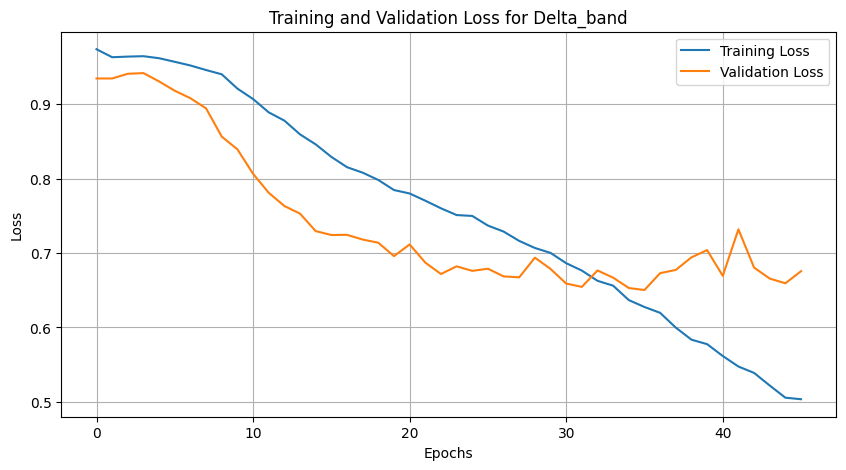

Training completed for Delta_band!
Processing test data for Delta_band...
Denoising completed for Delta_band!
Denoised Delta_band shape: (6800, 512)
Clean test Delta_band shape: (6800, 512)
Contaminated test Delta_band shape: (6800, 512)


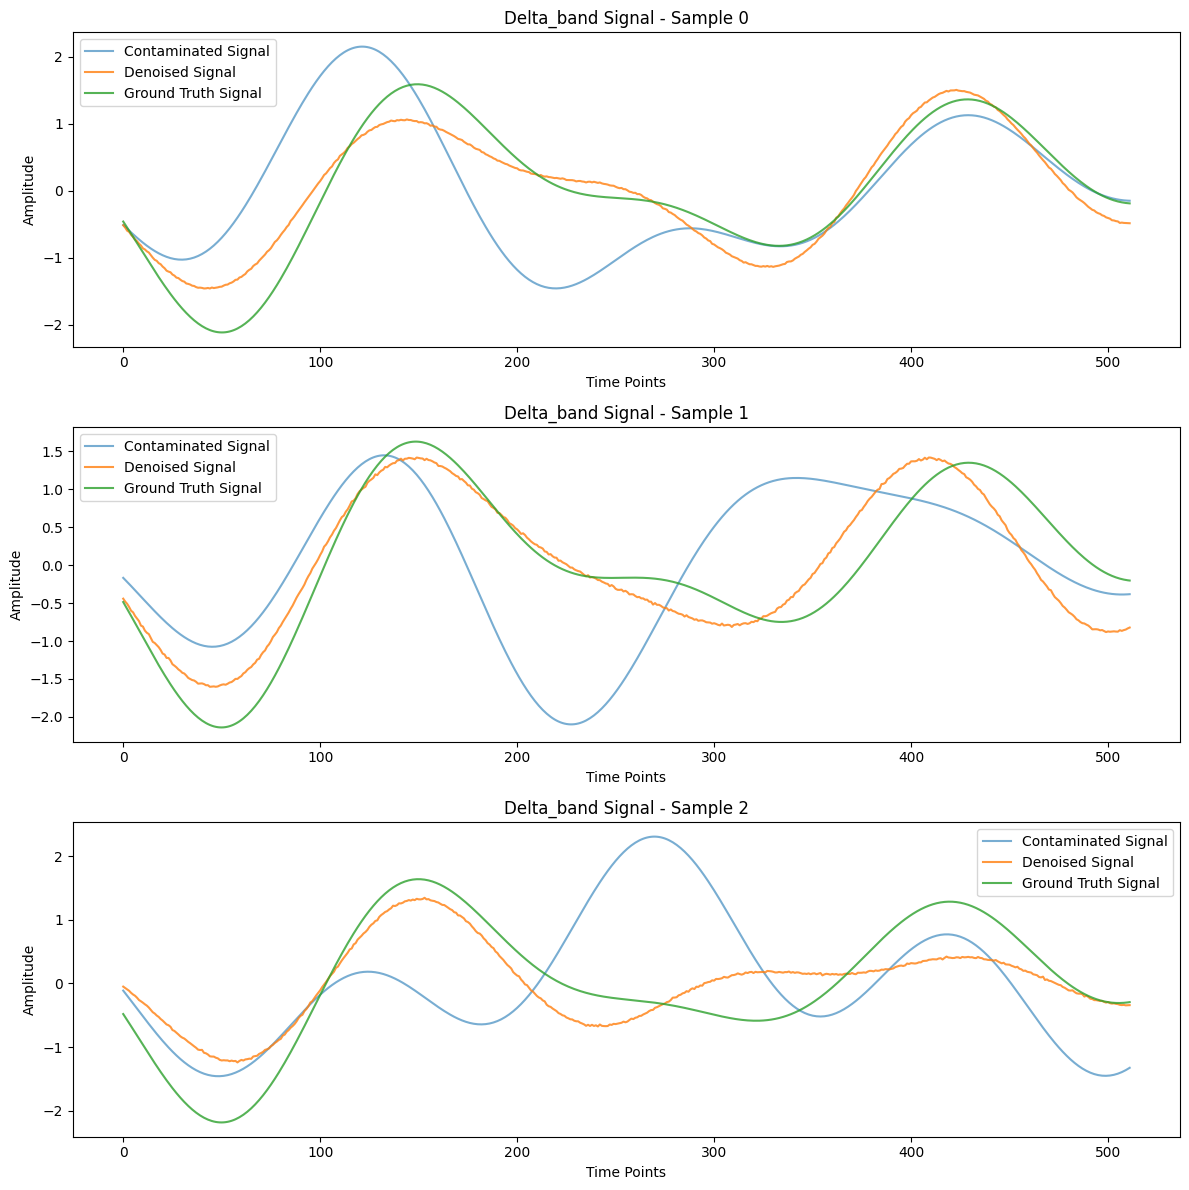


Processing Theta_band...
Found 10 SNR folders: ['SNR_-1', 'SNR_-2', 'SNR_-3', 'SNR_-4', 'SNR_-5', 'SNR_-6', 'SNR_-7', 'SNR_0', 'SNR_1', 'SNR_2']
Loaded SNR_-1 data for Theta_band with shape: (3400, 512)
Loaded SNR_-2 data for Theta_band with shape: (3400, 512)
Loaded SNR_-3 data for Theta_band with shape: (3400, 512)
Loaded SNR_-4 data for Theta_band with shape: (3400, 512)
Loaded SNR_-5 data for Theta_band with shape: (3400, 512)
Loaded SNR_-6 data for Theta_band with shape: (3400, 512)
Loaded SNR_-7 data for Theta_band with shape: (3400, 512)
Loaded SNR_0 data for Theta_band with shape: (3400, 512)
Loaded SNR_1 data for Theta_band with shape: (3400, 512)
Loaded SNR_2 data for Theta_band with shape: (3400, 512)
Combined contaminated Theta_band shape: (34000, 512)
Clean Theta_band shape: (3400, 512)
Clean Theta_band repeated shape: (34000, 512)
Normalizing signals for Theta_band...

Theta_band Dataset Shapes:
  Train Clean: (27200, 512), Train Contaminated: (27200, 512)
  Test Clean: 

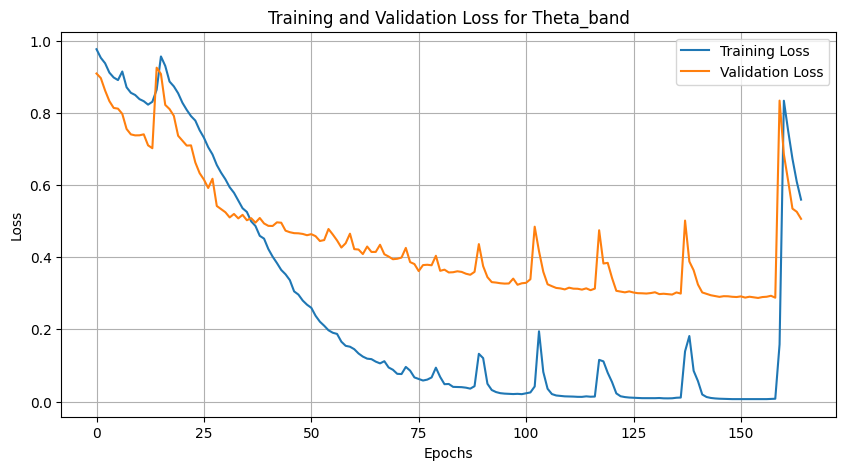

Training completed for Theta_band!
Processing test data for Theta_band...
Denoising completed for Theta_band!
Denoised Theta_band shape: (6800, 512)
Clean test Theta_band shape: (6800, 512)
Contaminated test Theta_band shape: (6800, 512)


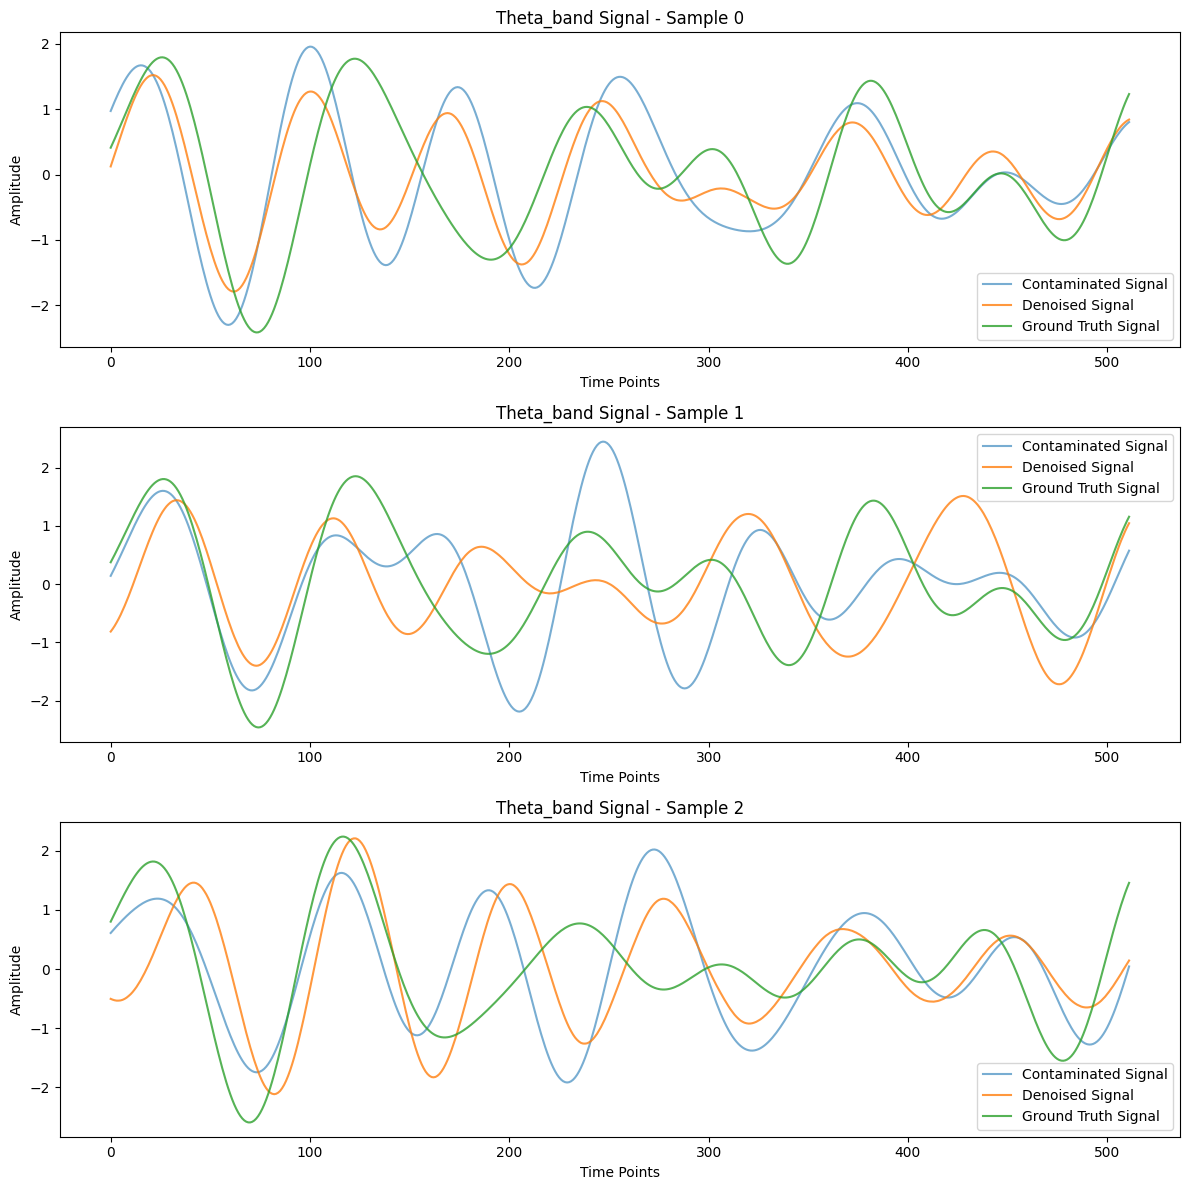


Processing Alpha_band...
Found 10 SNR folders: ['SNR_-1', 'SNR_-2', 'SNR_-3', 'SNR_-4', 'SNR_-5', 'SNR_-6', 'SNR_-7', 'SNR_0', 'SNR_1', 'SNR_2']
Loaded SNR_-1 data for Alpha_band with shape: (3400, 512)
Loaded SNR_-2 data for Alpha_band with shape: (3400, 512)
Loaded SNR_-3 data for Alpha_band with shape: (3400, 512)
Loaded SNR_-4 data for Alpha_band with shape: (3400, 512)
Loaded SNR_-5 data for Alpha_band with shape: (3400, 512)
Loaded SNR_-6 data for Alpha_band with shape: (3400, 512)
Loaded SNR_-7 data for Alpha_band with shape: (3400, 512)
Loaded SNR_0 data for Alpha_band with shape: (3400, 512)
Loaded SNR_1 data for Alpha_band with shape: (3400, 512)
Loaded SNR_2 data for Alpha_band with shape: (3400, 512)
Combined contaminated Alpha_band shape: (34000, 512)
Clean Alpha_band shape: (3400, 512)
Clean Alpha_band repeated shape: (34000, 512)
Normalizing signals for Alpha_band...

Alpha_band Dataset Shapes:
  Train Clean: (27200, 512), Train Contaminated: (27200, 512)
  Test Clean: 

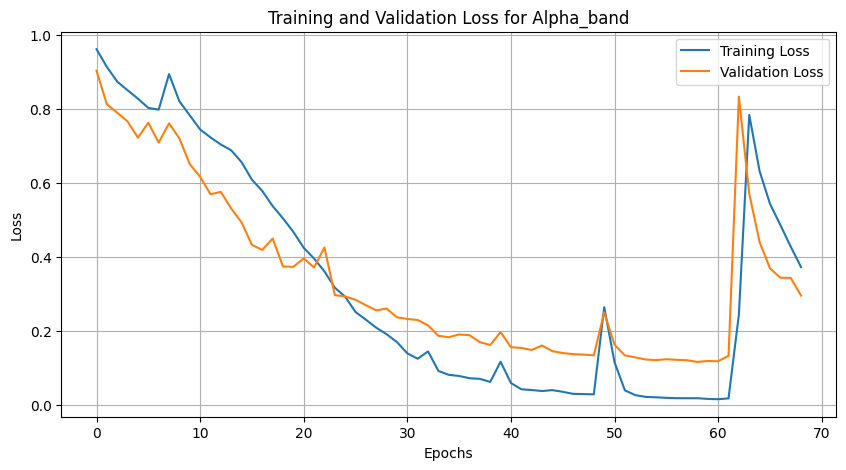

Training completed for Alpha_band!
Processing test data for Alpha_band...
Denoising completed for Alpha_band!
Denoised Alpha_band shape: (6800, 512)
Clean test Alpha_band shape: (6800, 512)
Contaminated test Alpha_band shape: (6800, 512)


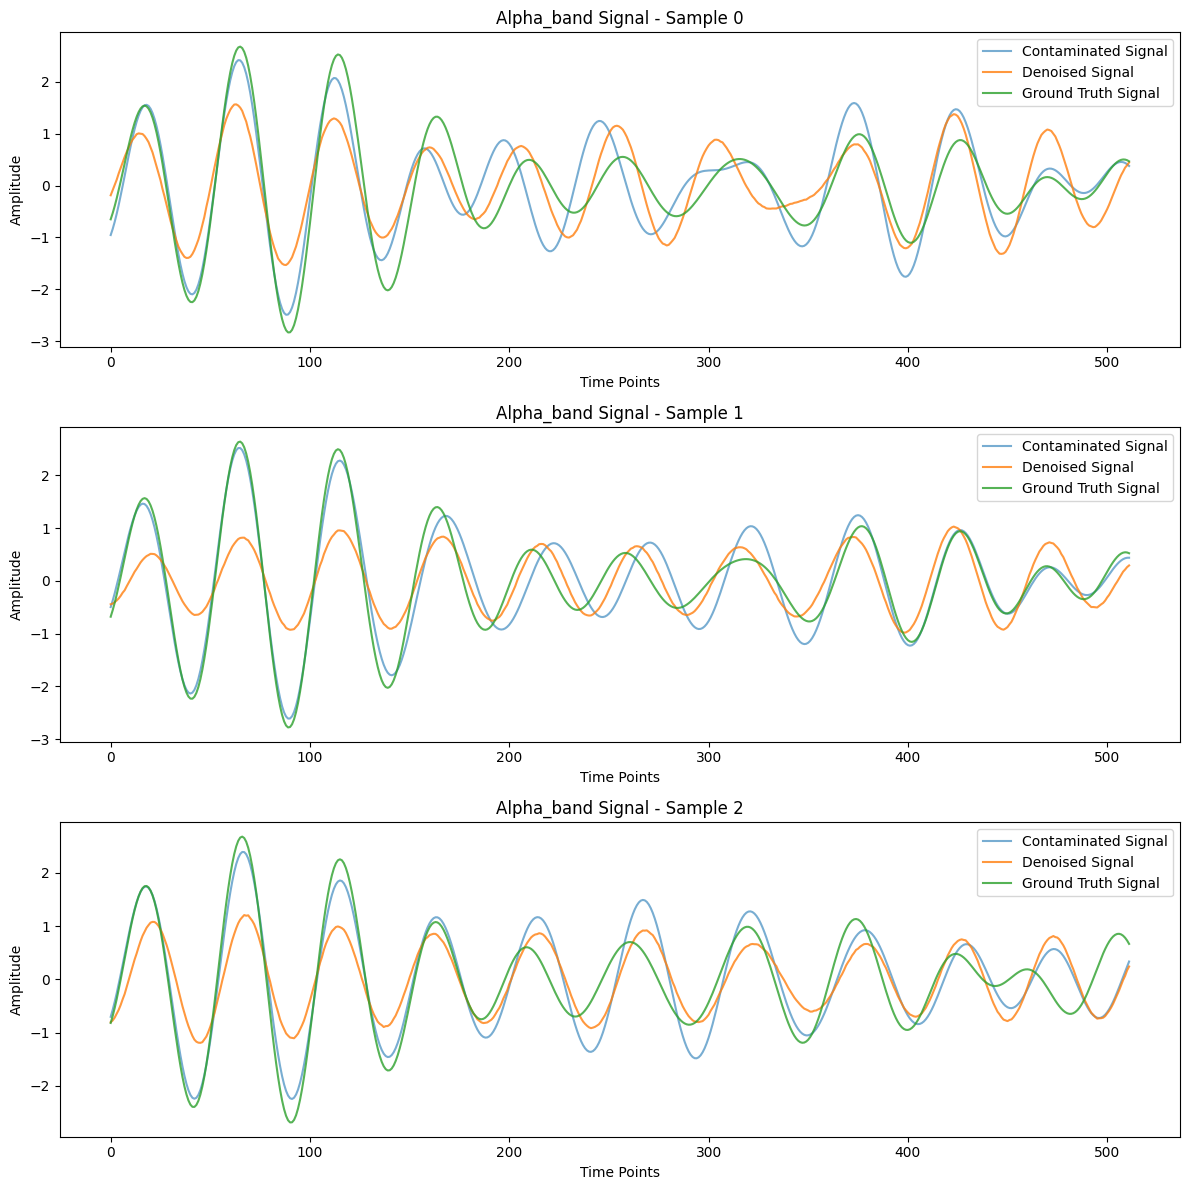


Processing Beta_band...
Found 10 SNR folders: ['SNR_-1', 'SNR_-2', 'SNR_-3', 'SNR_-4', 'SNR_-5', 'SNR_-6', 'SNR_-7', 'SNR_0', 'SNR_1', 'SNR_2']
Loaded SNR_-1 data for Beta_band with shape: (3400, 512)
Loaded SNR_-2 data for Beta_band with shape: (3400, 512)
Loaded SNR_-3 data for Beta_band with shape: (3400, 512)
Loaded SNR_-4 data for Beta_band with shape: (3400, 512)
Loaded SNR_-5 data for Beta_band with shape: (3400, 512)
Loaded SNR_-6 data for Beta_band with shape: (3400, 512)
Loaded SNR_-7 data for Beta_band with shape: (3400, 512)
Loaded SNR_0 data for Beta_band with shape: (3400, 512)
Loaded SNR_1 data for Beta_band with shape: (3400, 512)
Loaded SNR_2 data for Beta_band with shape: (3400, 512)
Combined contaminated Beta_band shape: (34000, 512)
Clean Beta_band shape: (3400, 512)
Clean Beta_band repeated shape: (34000, 512)
Normalizing signals for Beta_band...

Beta_band Dataset Shapes:
  Train Clean: (27200, 512), Train Contaminated: (27200, 512)
  Test Clean: (6800, 512), Tes

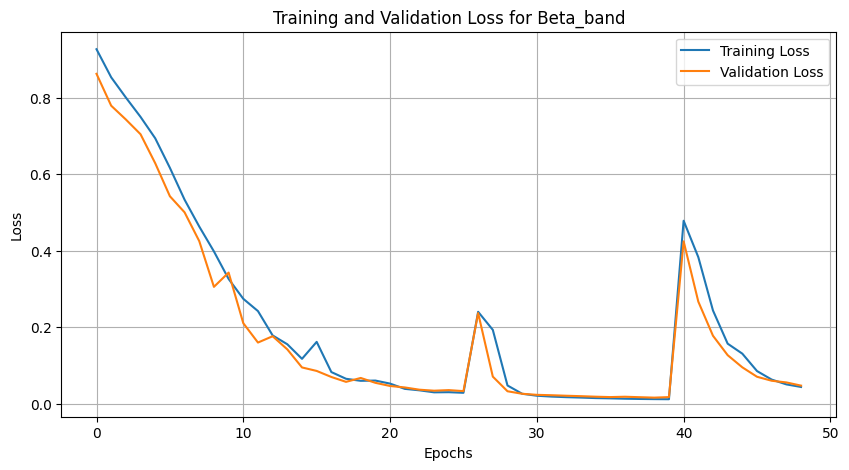

Training completed for Beta_band!
Processing test data for Beta_band...
Denoising completed for Beta_band!
Denoised Beta_band shape: (6800, 512)
Clean test Beta_band shape: (6800, 512)
Contaminated test Beta_band shape: (6800, 512)


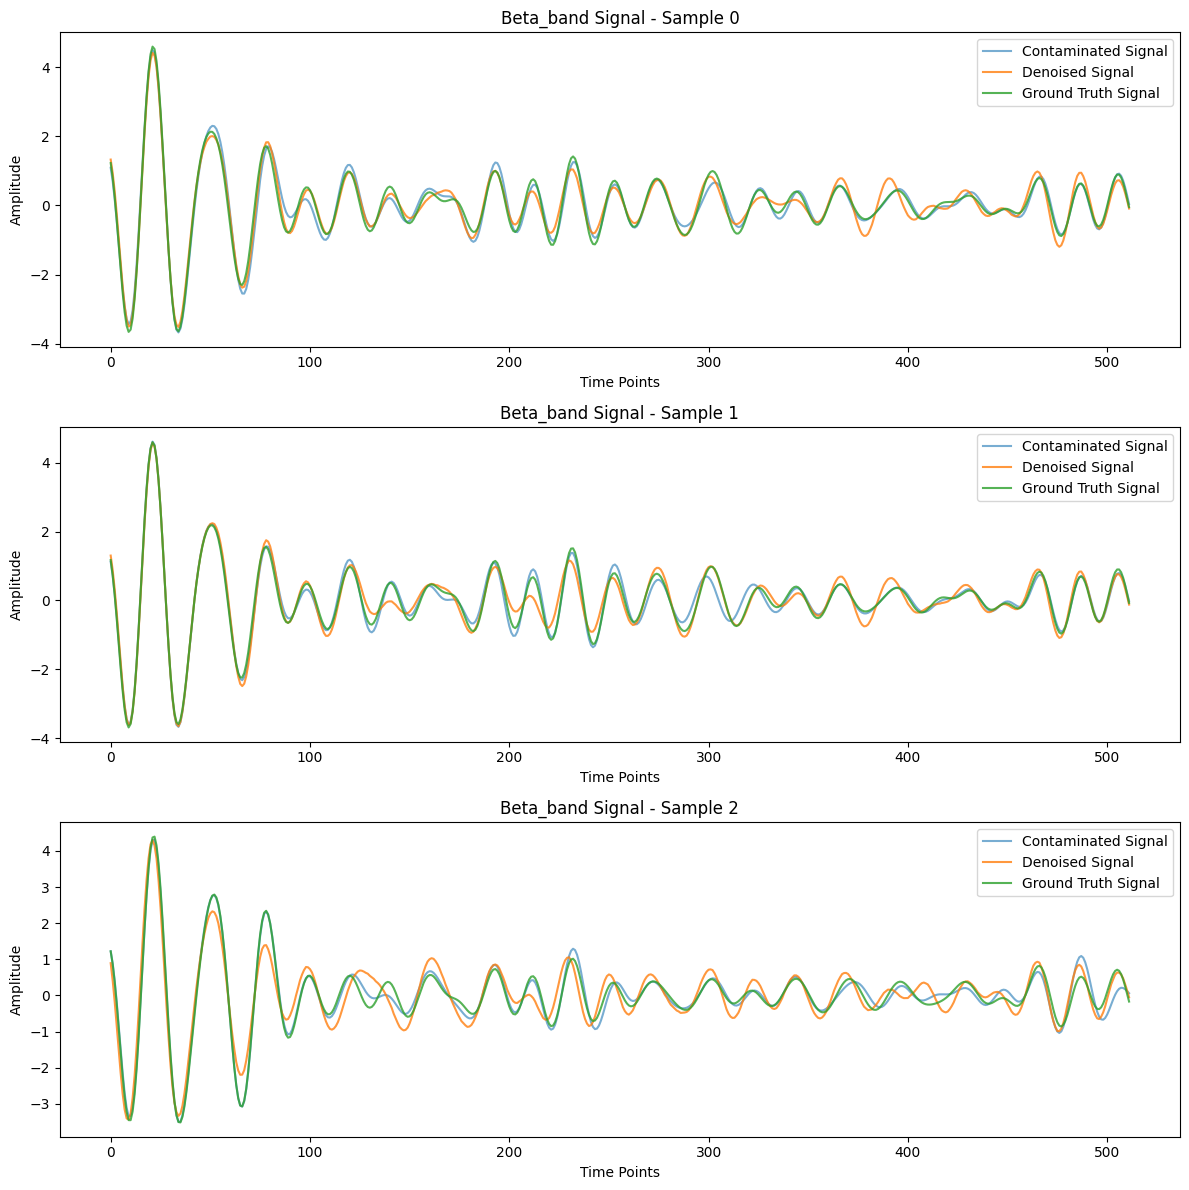


Processing Gamma_band...
Found 10 SNR folders: ['SNR_-1', 'SNR_-2', 'SNR_-3', 'SNR_-4', 'SNR_-5', 'SNR_-6', 'SNR_-7', 'SNR_0', 'SNR_1', 'SNR_2']
Loaded SNR_-1 data for Gamma_band with shape: (3400, 512)
Loaded SNR_-2 data for Gamma_band with shape: (3400, 512)
Loaded SNR_-3 data for Gamma_band with shape: (3400, 512)
Loaded SNR_-4 data for Gamma_band with shape: (3400, 512)
Loaded SNR_-5 data for Gamma_band with shape: (3400, 512)
Loaded SNR_-6 data for Gamma_band with shape: (3400, 512)
Loaded SNR_-7 data for Gamma_band with shape: (3400, 512)
Loaded SNR_0 data for Gamma_band with shape: (3400, 512)
Loaded SNR_1 data for Gamma_band with shape: (3400, 512)
Loaded SNR_2 data for Gamma_band with shape: (3400, 512)
Combined contaminated Gamma_band shape: (34000, 512)
Clean Gamma_band shape: (3400, 512)
Clean Gamma_band repeated shape: (34000, 512)
Normalizing signals for Gamma_band...

Gamma_band Dataset Shapes:
  Train Clean: (27200, 512), Train Contaminated: (27200, 512)
  Test Clean: 

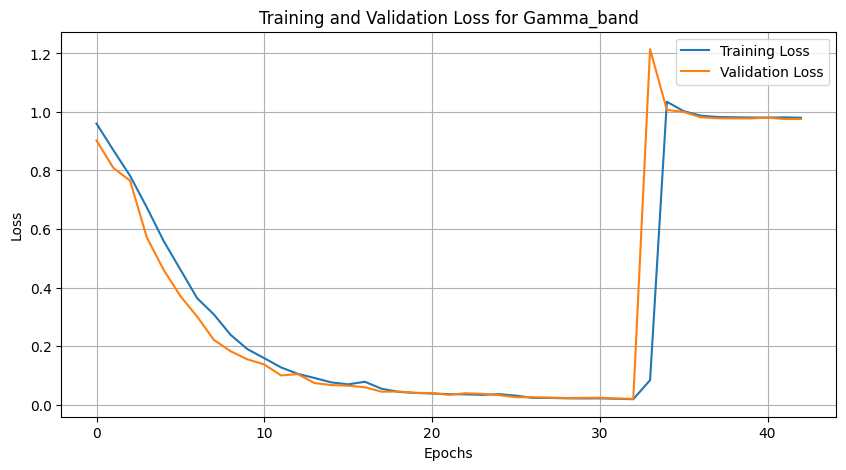

Training completed for Gamma_band!
Processing test data for Gamma_band...
Denoising completed for Gamma_band!
Denoised Gamma_band shape: (6800, 512)
Clean test Gamma_band shape: (6800, 512)
Contaminated test Gamma_band shape: (6800, 512)


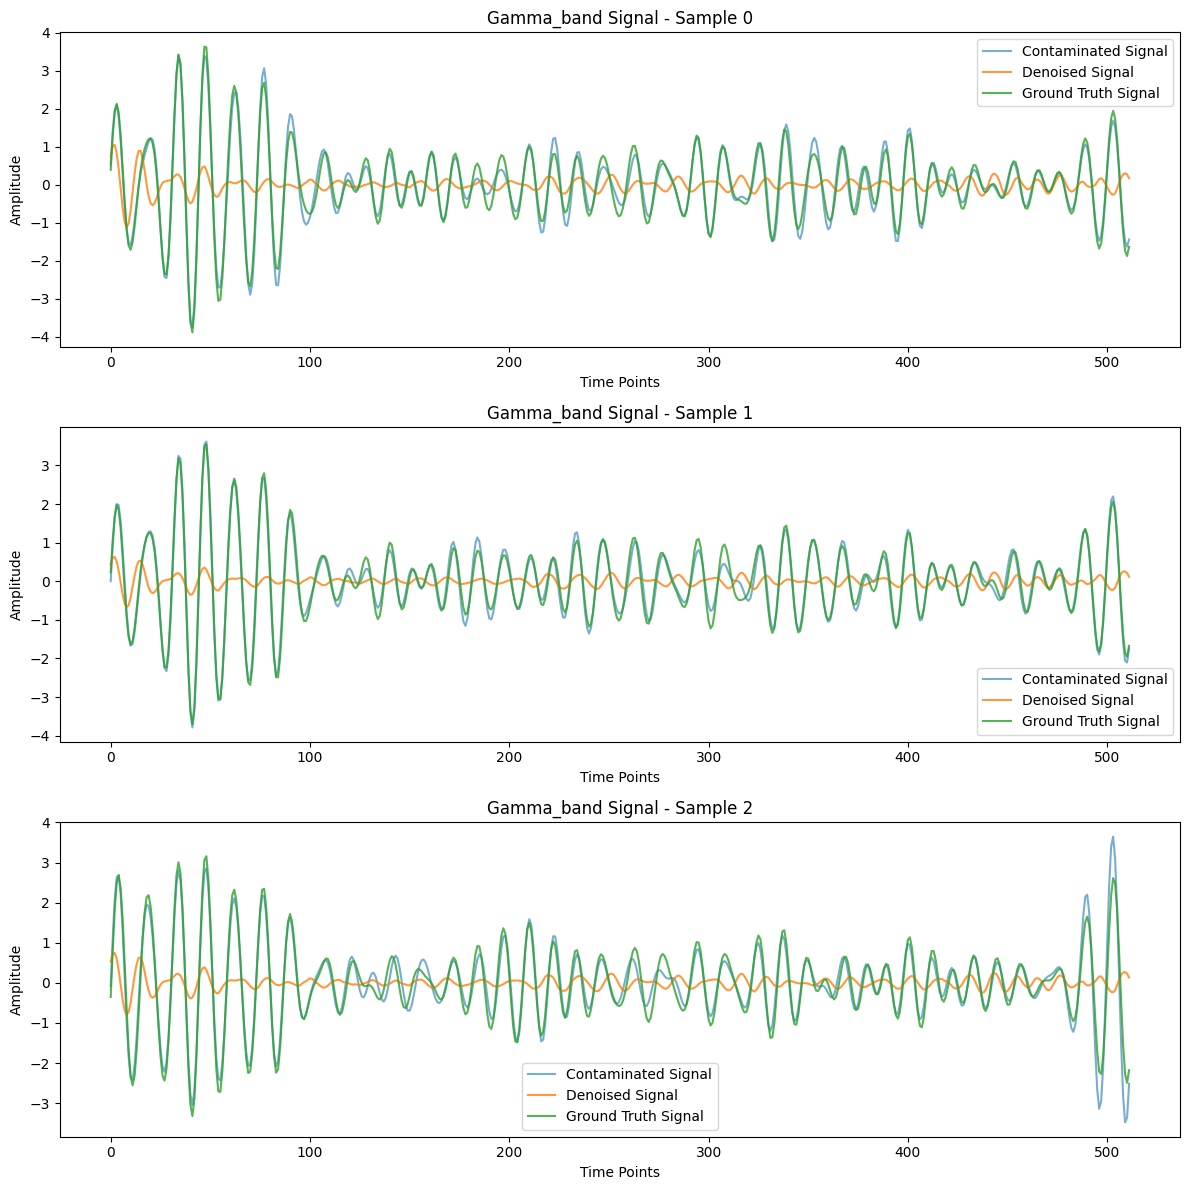


Processing High_Frequencies_band...
Found 10 SNR folders: ['SNR_-1', 'SNR_-2', 'SNR_-3', 'SNR_-4', 'SNR_-5', 'SNR_-6', 'SNR_-7', 'SNR_0', 'SNR_1', 'SNR_2']
Loaded SNR_-1 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_-2 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_-3 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_-4 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_-5 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_-6 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_-7 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_0 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_1 data for High_Frequencies_band with shape: (3400, 512)
Loaded SNR_2 data for High_Frequencies_band with shape: (3400, 512)
Combined contaminated High_Frequencies_band shape: (34000, 512)
Clean High_Frequencies_band shape: (3400, 512)
Clean High_Frequencies_band repeated shape: (

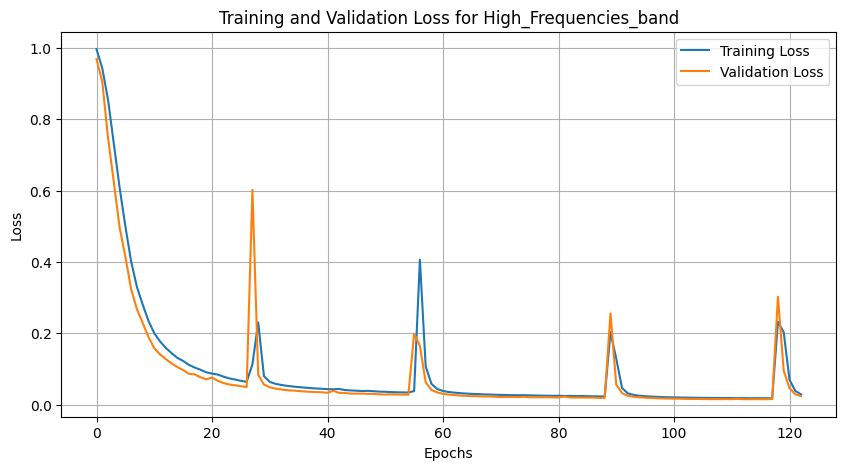

Training completed for High_Frequencies_band!
Processing test data for High_Frequencies_band...
Denoising completed for High_Frequencies_band!
Denoised High_Frequencies_band shape: (6800, 512)
Clean test High_Frequencies_band shape: (6800, 512)
Contaminated test High_Frequencies_band shape: (6800, 512)


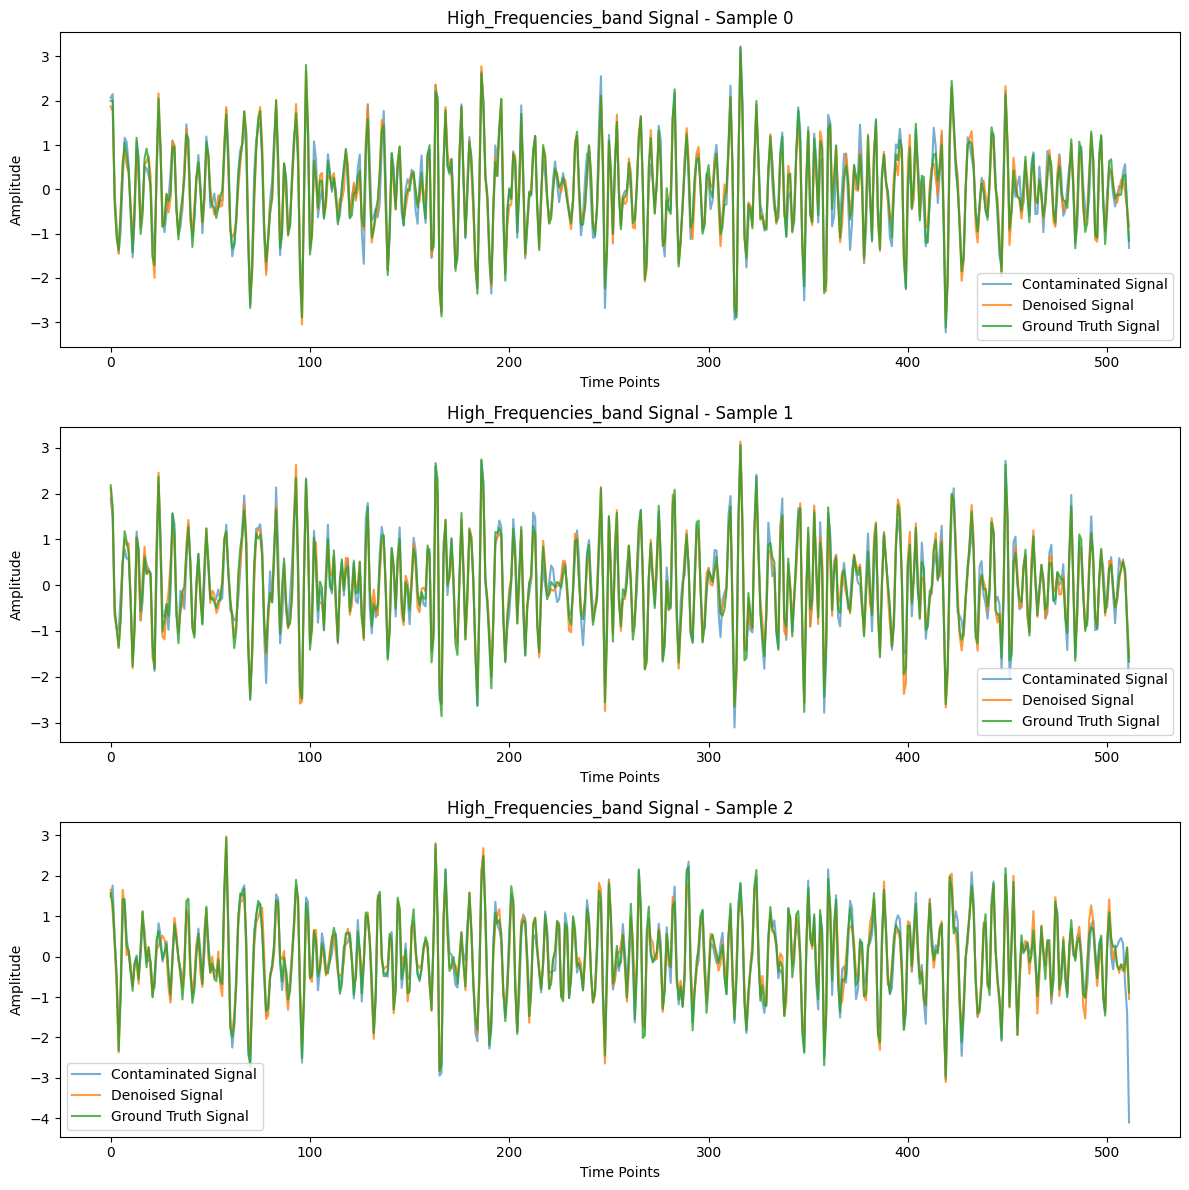

In [59]:
denoised_bands, clean_bands, contaminated_bands = process_all_bands()

In [60]:
def reconstruct_and_evaluate(denoised_bands, clean_bands, contaminated_bands):
    print("\nReconstructing EEG signals...")
    
    # Verify array dimensions
    for i, band in enumerate(bands[:len(denoised_bands)]):
        print(f"{band} shapes - Denoised: {denoised_bands[i].shape}, Clean: {clean_bands[i].shape}, Contaminated: {contaminated_bands[i].shape}")
    
    # Reconstruct full EEG signals by summing across bands
    denoised_eeg = np.sum(denoised_bands, axis=0)
    clean_eeg = np.sum(clean_bands, axis=0)
    contaminated_eeg = np.sum(contaminated_bands, axis=0)

    print(f"Reconstructed EEG Shapes - Clean: {clean_eeg.shape}, Denoised: {denoised_eeg.shape}, Contaminated: {contaminated_eeg.shape}")

    # Evaluate Full EEG Reconstruction
    print("\nCalculating evaluation metrics...")
    rrmse_t = compute_rrmse_t(clean_eeg, denoised_eeg)
    rrmse_s = compute_rrmse_s(clean_eeg, denoised_eeg, fs=512)
    cc = compute_cc(clean_eeg, denoised_eeg)

    print("\nEvaluation Metrics for Full EEG Denoising:")
    print(f"  RRMSE_t: {rrmse_t:.4f}")
    print(f"  RRMSE_s: {rrmse_s:.4f}")
    print(f"  CC: {cc:.4f}")

    # Plot reconstructed signals
    plot_signals(
        contaminated_eeg, 
        denoised_eeg, 
        clean_eeg, 
        sample_indices=[0, 100, 200], 
        title="Full EEG Signal"
    )
    
    return denoised_eeg, clean_eeg, contaminated_eeg

print("Reconstruction and evaluation function defined!")

Reconstruction and evaluation function defined!



Reconstructing EEG signals...
Delta_band shapes - Denoised: (6800, 512), Clean: (6800, 512), Contaminated: (6800, 512)
Theta_band shapes - Denoised: (6800, 512), Clean: (6800, 512), Contaminated: (6800, 512)
Alpha_band shapes - Denoised: (6800, 512), Clean: (6800, 512), Contaminated: (6800, 512)
Beta_band shapes - Denoised: (6800, 512), Clean: (6800, 512), Contaminated: (6800, 512)
Gamma_band shapes - Denoised: (6800, 512), Clean: (6800, 512), Contaminated: (6800, 512)
High_Frequencies_band shapes - Denoised: (6800, 512), Clean: (6800, 512), Contaminated: (6800, 512)
Reconstructed EEG Shapes - Clean: (6800, 512), Denoised: (6800, 512), Contaminated: (6800, 512)

Calculating evaluation metrics...

Evaluation Metrics for Full EEG Denoising:
  RRMSE_t: 0.6372
  RRMSE_s: 0.4933
  CC: 0.7664


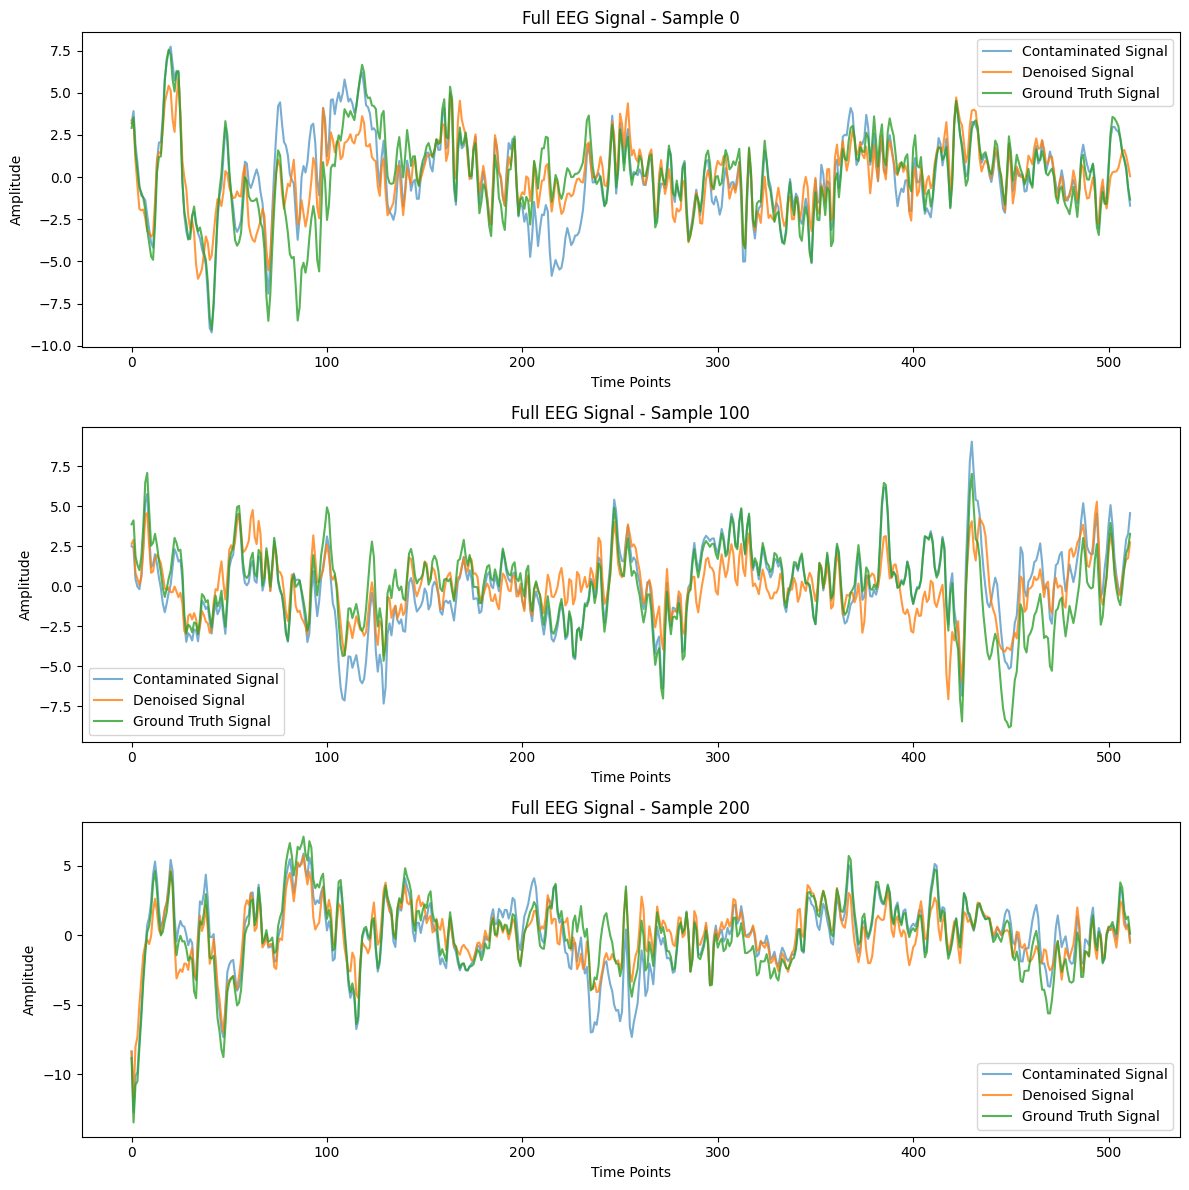

In [61]:
denoised_eeg, clean_eeg, contaminated_eeg = reconstruct_and_evaluate(denoised_bands, clean_bands, contaminated_bands)
